# Exploratory Data Analysis of the Knowledge Graph using Neo4j

## Connecting to Neo4j

In [59]:
from neo4j import GraphDatabase
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

driver=GraphDatabase.driver(uri="bolt://localhost:7687",auth=("neo4j","biomedical_kg"))
session=driver.session()

## 1. Statistics on node, relationships and properties

In [46]:
q = """
MATCH (n)
WITH labels(n) as labels, size(keys(n)) as props, size((n)--()) as degree
RETURN
DISTINCT labels,
count(*) AS Num_of_Nodes,
avg(props) AS Avg_Num_Of_Prop_Per_Node,
min(props) AS Min_Num_Prop_Per_Node,
max(props) AS Max_Num_Prop_Per_Node,
avg(degree) AS Avg_Num_Of_Relationships,
min(degree) AS Min_Num_Of_Relationships,
max(degree) AS Max_Num_Of_Relationships
"""

results=session.run(q)
data=pd.DataFrame(results.data())
data

,labels,Num_of_Nodes,Avg_Num_Of_Prop_Per_Node,Min_Num_Prop_Per_Node,Max_Num_Prop_Per_Node,Avg_Num_Of_Relationships,Min_Num_Of_Relationships,Max_Num_Of_Relationships
0,[drug],5182,1.000000,1,1,6.894056,0,2868
1,[gene],11727,1.446576,1,6,3.342202,1,101
2,[protein],13154,3.635396,1,5,7.027824,1,1125
3,[disease],1,5.000000,5,5,2981.000000,2981,2981


Drug: Total Regulations

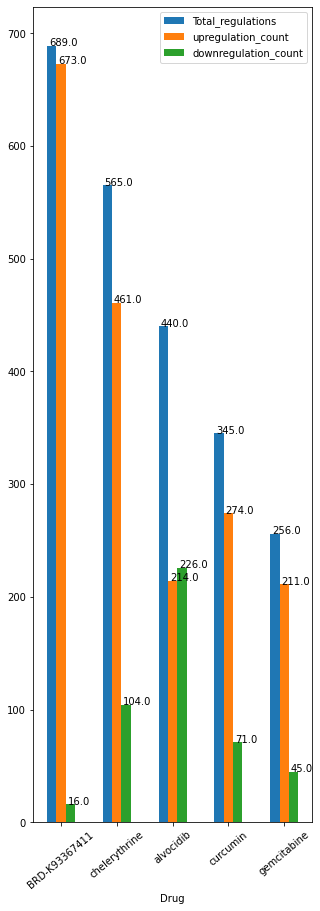

In [74]:
q = """MATCH (a:drug)-[r:upregulates]->(b)
WITH a,
    COUNT(r) as upregulation_count
RETURN a.Name as Drug,upregulation_count"""

results=session.run(q)
data1=pd.DataFrame(results.data())

q = """MATCH (a:drug)-[r:downregulates]->(b)
WITH a,
    COUNT(r) as downregulation_count
RETURN a.Name as Drug,downregulation_count"""

results=session.run(q)
data2=pd.DataFrame(results.data())

combined_df = pd.merge(data1, data2, on='Drug', how='outer')

#Replace NaN with 0
combined_df = combined_df.fillna(0)

#Create a new column that is the sum of the down_regulation and up_regulation columns
combined_df['Total_regulations'] = combined_df['downregulation_count'] + combined_df['upregulation_count']
combined_df = combined_df.sort_values(by=['Total_regulations'], ascending=False)
combined_df.reset_index(drop=True, inplace=True)
combined_df

fig, ax = plt.subplots(figsize=(5,15))
combined_df.head().plot.bar(x = 'Drug', y = ['Total_regulations', 'upregulation_count', 'downregulation_count'], rot = 40, ax = ax)
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/5., p.get_height()))

DRUG: Max Products

In [54]:
q = """MATCH (a:gene)-[r:product]->(b)
WITH a,
    COUNT(r) as No_of_Products
RETURN a.Name as Gene,No_of_Products"""

results=session.run(q)
data=pd.DataFrame(results.data())
data

,Gene,No_of_Products
0,INS,1
1,RAB5C,1
2,CD59,1
3,KLC2,1
4,KIF5A,1
...,...,...
483,KY,1
484,EIF3CL,1
485,SLC6A5,1
486,IL15RA,1


PROTEIN: Max Relationships

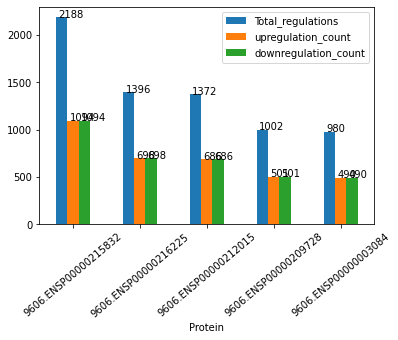

In [71]:
q = """MATCH (a:protein)-[r:interacts_with]->(b)
WITH a,
    COUNT(r) as upregulation_count
RETURN a.Name as Protein,upregulation_count"""

results=session.run(q)
data1=pd.DataFrame(results.data())

q = """MATCH (a:protein)-[r:interacts_with]->(b)
WITH a,
    COUNT(r) as downregulation_count
RETURN a.Name as Protein,downregulation_count"""

results=session.run(q)
data2=pd.DataFrame(results.data())

combined_df = pd.merge(data1, data2, on='Protein', how='outer')

#Replace NaN with 0
combined_df = combined_df.fillna(0)

#Create a new column that is the sum of the down_regulation and up_regulation columns
combined_df['Total_regulations'] = combined_df['downregulation_count'] + combined_df['upregulation_count']
combined_df = combined_df.sort_values(by=['Total_regulations'], ascending=False)
combined_df.reset_index(drop=True, inplace=True)
combined_df

fig, ax = plt.subplots()
combined_df.head().plot.bar(x = 'Protein', y = ['Total_regulations', 'upregulation_count', 'downregulation_count'], rot = 40, ax = ax)
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/5., p.get_height()))

DISEASE: Total Interactions

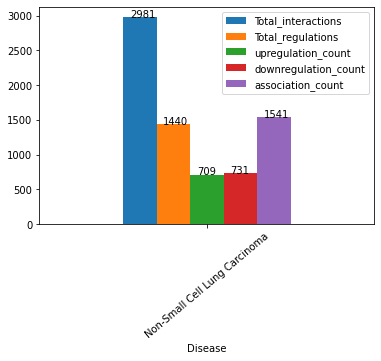

In [70]:
q = """MATCH (a:disease)-[r:downregulates]->(b)
WITH a,
    COUNT(r) as downregulation_count
RETURN a.Name as Disease,downregulation_count
"""

results=session.run(q)
data1=pd.DataFrame(results.data())

q = """MATCH (a:disease)-[r:upregulates]->(b)
WITH a,
    COUNT(r) as upregulation_count
RETURN a.Name as Disease,upregulation_count"""

results=session.run(q)
data2=pd.DataFrame(results.data())

q = """MATCH (a:disease)-[r:associated_with]->(b)
WITH a,
    COUNT(r) as association_count
RETURN a.Name as Disease,association_count"""

results=session.run(q)
data3=pd.DataFrame(results.data())

combined_df = pd.merge(data1, data2, on='Disease', how='outer')

#Replace NaN with 0
combined_df = combined_df.fillna(0)

#Create a new column that is the sum of the down_regulation and up_regulation columns
combined_df['Total_regulations'] = combined_df['downregulation_count'] + combined_df['upregulation_count']
combined_df = combined_df.sort_values(by=['Total_regulations'], ascending=False)
combined_df.reset_index(drop=True, inplace=True)

combined_df = pd.merge(combined_df, data3, on='Disease', how='outer')
#Replace NaN with 0
combined_df = combined_df.fillna(0)
#Create a new column that is the sum of the down_regulation and up_regulation columns
combined_df['Total_interactions'] = combined_df['Total_regulations'] + combined_df['association_count']
combined_df = combined_df.sort_values(by=['Total_interactions'], ascending=False)
combined_df.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()
combined_df.head().plot.bar(x = 'Disease', y = ['Total_interactions','Total_regulations', 'upregulation_count', 'downregulation_count', 'association_count'], rot = 40, ax = ax)
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/5., p.get_height()))

## 2. Gene connectivity statistics

### 2.1 Genes with highest number of drug interactions leading to it's upregulation

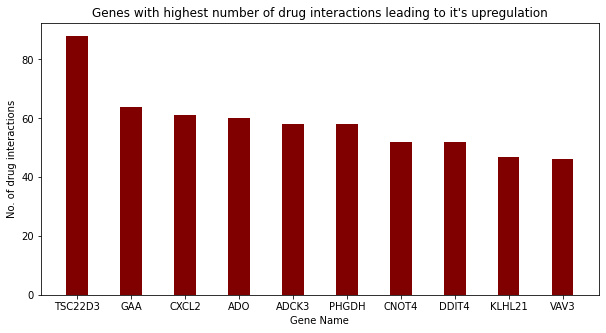

In [3]:
q = """MATCH (b:gene)
WITH b, SIZE(()-[:upregulates]->(b)) as upregulation_count
ORDER BY upregulation_count DESC LIMIT 10
MATCH (a)-[:upregulates]->(b)
RETURN b.Name as Gene_Name, COUNT(a.Name) as Drugs"""

results=session.run(q)
data=pd.DataFrame(results.data())

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(data["Gene_Name"], data["Drugs"], color ='maroon',
        width = 0.4)
 
plt.xlabel("Gene Name")
plt.ylabel("No. of drug interactions")
plt.title("Genes with highest number of drug interactions leading to it's upregulation")
plt.show()

### 2.2 Genes with highest number of drug interactions leading to it's downregulation

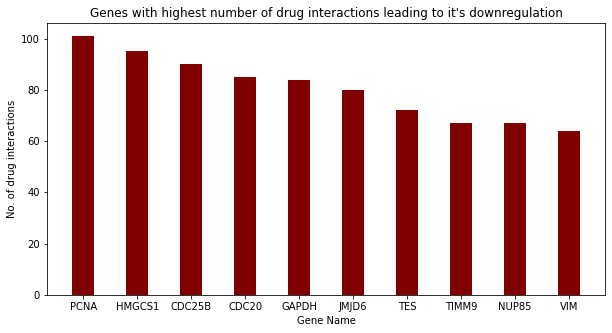

In [4]:
q = """MATCH (b:gene)
WITH b, SIZE(()-[:downregulates]->(b)) as downregulation_count
ORDER BY downregulation_count DESC LIMIT 10
MATCH (a)-[:downregulates]->(b)
RETURN b.Name as Gene_Name, COUNT(a.Name) as Drugs"""

results=session.run(q)
data=pd.DataFrame(results.data())

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(data["Gene_Name"], data["Drugs"], color ='maroon',
        width = 0.4)
 
plt.xlabel("Gene Name")
plt.ylabel("No. of drug interactions")
plt.title("Genes with highest number of drug interactions leading to it's downregulation")
plt.show()

### 2.3 Genes that are downregulated with Non-Small Cell Lung Carcinoma

In [5]:
q = """MATCH (b:gene)
WITH b, SIZE(()-[:downregulates]->(b)) as downregulation_count
ORDER BY downregulation_count DESC
MATCH (a)-[:downregulates]->(b)
WHERE a.Name = 'Non-Small Cell Lung Carcinoma'
RETURN (a.Name) as Disease, b.Name as Gene_Name"""

results=session.run(q)
data = pd.DataFrame(results.data())
data.head()

,Disease,Gene_Name
0,Non-Small Cell Lung Carcinoma,TXLNA
1,Non-Small Cell Lung Carcinoma,EBNA1BP2
2,Non-Small Cell Lung Carcinoma,ECH1
3,Non-Small Cell Lung Carcinoma,RRAGA
4,Non-Small Cell Lung Carcinoma,PAPD7


### 2.4 Genes that are upregulated with Non-Small Cell Lung Carcinoma

In [6]:
q = """MATCH (b:gene)
WITH b, SIZE(()-[:upregulates]->(b)) as upregulation_count
ORDER BY upregulation_count DESC
MATCH (a)-[:upregulates]->(b)
WHERE a.Name = 'Non-Small Cell Lung Carcinoma'
RETURN (a.Name) as Disease, b.Name as Gene_Name"""

results=session.run(q)
data=pd.DataFrame(results.data())
data.head()

,Disease,Gene_Name
0,Non-Small Cell Lung Carcinoma,PCK2
1,Non-Small Cell Lung Carcinoma,SYPL1
2,Non-Small Cell Lung Carcinoma,CHM
3,Non-Small Cell Lung Carcinoma,PLSCR1
4,Non-Small Cell Lung Carcinoma,SOX2


## 3 Drug connectivity statistics

### 3.1 What one drug is interacting the most with the downregulated genes?

In [7]:
q = """MATCH (b:drug)
WITH b, SIZE((b)-[:downregulates]->()) as downregulation_count
ORDER BY downregulation_count DESC LIMIT 5
MATCH (b)-[:downregulates]->(c)
RETURN c.Name as Gene_Name, (b.Name) as Drugs"""

results=session.run(q)
data=pd.DataFrame(results.data())
data.head()

,Gene_Name,Drugs
0,SLC4A7,alvocidib
1,NUBP1,alvocidib
2,FOXJ3,alvocidib
3,PPP4R3A,alvocidib
4,SLC22A3,alvocidib


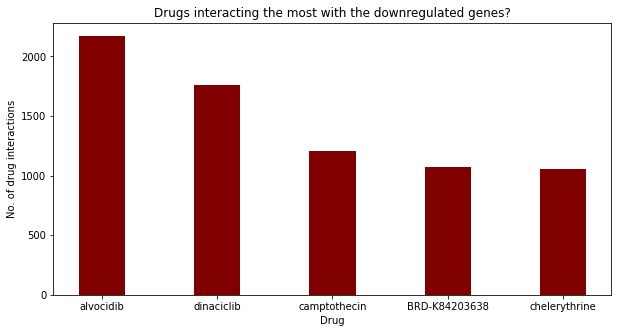

In [8]:
data_2 = pd.DataFrame.from_dict(Counter(data['Drugs']), orient='index').reset_index()
data_2.columns = ['Drug', 'downregulation_count']

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(data_2["Drug"], data_2["downregulation_count"], color ='maroon',
        width = 0.4)
 
plt.xlabel("Drug")
plt.ylabel("No. of drug interactions")
plt.title("Drugs interacting the most with the downregulated genes?")
plt.show()

### 3.2 What one drug is interacting the most with the upregulated genes?

In [9]:
q = """MATCH (b:drug)
WITH b, SIZE((b)-[:upregulates]->()) as upregulation_count
ORDER BY upregulation_count DESC LIMIT 5
MATCH (b)-[:upregulates]->(c)
RETURN c.Name as Gene_Name, (b.Name) as Drugs"""

results=session.run(q)
data=pd.DataFrame(results.data())
data.head()

,Gene_Name,Drugs
0,DUSP13,BRD-K93367411
1,ADPRM,BRD-K93367411
2,GMEB2,BRD-K93367411
3,HNRNPH3,BRD-K93367411
4,WDYHV1,BRD-K93367411


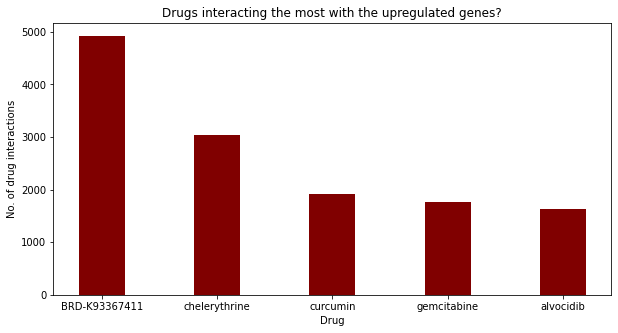

In [10]:
data_3 = pd.DataFrame.from_dict(Counter(data['Drugs']), orient='index').reset_index()
data_3.columns = ['Drug', 'upregulation_count']

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(data_3["Drug"], data_3["upregulation_count"], color ='maroon',
        width = 0.4)
 
plt.xlabel("Drug")
plt.ylabel("No. of drug interactions")
plt.title("Drugs interacting the most with the upregulated genes?")
plt.show()

## 4. Proteins with highest number of interactions

In [11]:
q = """MATCH (a:protein)-[r:interacts_with]->(b:protein)
WITH b, 
     COUNT(r) AS authorsCount
     ORDER BY authorsCount DESC LIMIT 10
MATCH (b)<-[:interacts_with]-(a:protein)
RETURN b.Preferred_name as Protein_node, a.Preferred_name as Interacts_with
"""

results=session.run(q)
data=pd.DataFrame(results.data())
data.head()

,Protein_node,Interacts_with
0,AKT1,FKBP4
1,AKT1,CD74
2,AKT1,DVL2
3,AKT1,MAPK12
4,AKT1,CDH17


## 5. Which drug reverses the most number of dysregulated NSCLC genes?

### 5.1 Finding the drugs that upregulate the most number of downregulated NSCLC genes

            Drug  downregulation_count
0      alvocidib                   121
1     dinaciclib                   101
2   camptothecin                    87
3     trametinib                    56
4   narciclasine                    53
5  chelerythrine                    53
6     entinostat                    52
7    palbociclib                    52
8       apicidin                    50
9  BRD-K84203638                    47


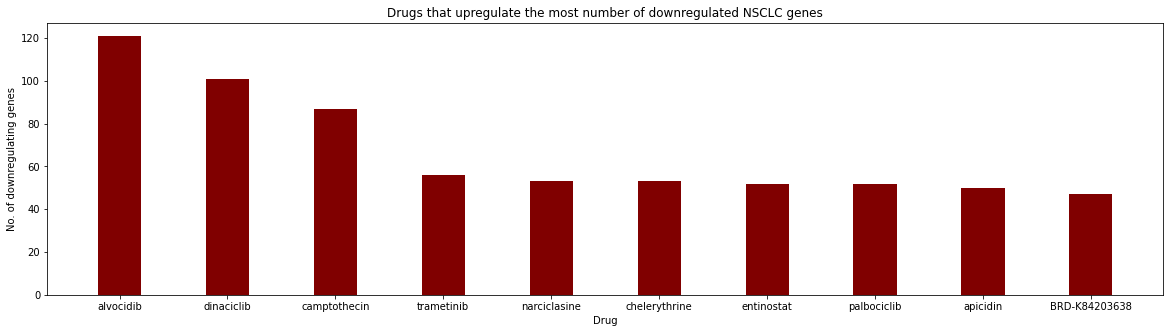

In [10]:
q = """
MATCH ((disease {Name:'Non-Small Cell Lung Carcinoma'})-[:upregulates]->(gene)<-[r:downregulates]-(a:drug))
WITH a,
    COUNT(r) as downregulation_count
    ORDER BY downregulation_count DESC LIMIT 10
RETURN a.Name as Drug,downregulation_count"""

results=session.run(q)
data1=pd.DataFrame(results.data())
print(data1)
fig = plt.figure(figsize = (20, 5))
 
# creating the bar plot
plt.bar(data1["Drug"], data1["downregulation_count"], color ='maroon',
        width = 0.4)
 
plt.xlabel("Drug")
plt.ylabel("No. of downregulating genes")
plt.title("Drugs that upregulate the most number of downregulated NSCLC genes")
plt.show()

### 5.2 Finding the drugs that downregulate the most number of upregulated NSCLC genes

            Drug  upregulation_count
0  chelerythrine                 211
1  BRD-K93367411                 189
2      alvocidib                 129
3       curcumin                 120
4    gemcitabine                  85
5   narciclasine                  84
6  BRD-K84203638                  74
7   camptothecin                  71
8    saracatinib                  68
9           A-66                  67


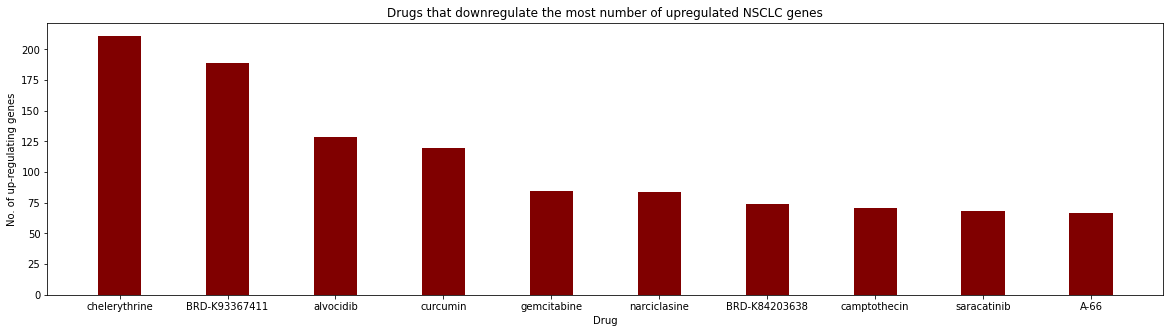

In [11]:
q = """MATCH (disease {Name:'Non-Small Cell Lung Carcinoma'})-[:downregulates]->(gene)<-[r:upregulates]-(a:drug)
WITH a,
    COUNT(r) as upregulation_count
    ORDER BY upregulation_count DESC LIMIT 10
RETURN a.Name as Drug,upregulation_count"""

results=session.run(q)
data2=pd.DataFrame(results.data())
print(data2)
fig = plt.figure(figsize = (20, 5))
 
# creating the bar plot
plt.bar(data2["Drug"], data2["upregulation_count"], color ='maroon',
        width = 0.4)
 
plt.xlabel("Drug")
plt.ylabel("No. of up-regulating genes")
plt.title("Drugs that downregulate the most number of upregulated NSCLC genes")
plt.show()

In [26]:
combined_df = pd.merge(data1, data2, on='Drug', how='outer')

#Replace NaN with 0
combined_df = combined_df.fillna(0)

#Create a new column that is the sum of the down_regulation and up_regulation columns
combined_df['Total_regulations'] = combined_df['downregulation_count'] + combined_df['upregulation_count']
combined_df = combined_df.sort_values(by=['Total_regulations'], ascending=False)
combined_df.reset_index(drop=True, inplace=True)
print(combined_df)

             Drug  downregulation_count  upregulation_count  Total_regulations
0   chelerythrine                  53.0               211.0              264.0
1       alvocidib                 121.0               129.0              250.0
2   BRD-K93367411                   0.0               189.0              189.0
3    camptothecin                  87.0                71.0              158.0
4    narciclasine                  53.0                84.0              137.0
5   BRD-K84203638                  47.0                74.0              121.0
6        curcumin                   0.0               120.0              120.0
7      dinaciclib                 101.0                 0.0              101.0
8     gemcitabine                   0.0                85.0               85.0
9     saracatinib                   0.0                68.0               68.0
10           A-66                   0.0                67.0               67.0
11     trametinib                  56.0             